### Sampling Methods for Imbalanced Samples
#### Project for the Statistical Modelling Course - Felix Adam

### 1. Introduction

There are many classification tasks, which try to deal with finding rare cases, such as diseases, oil spills or fraudulent customers. What makes these tasks difficult is the low prevalence of "interesting" cases in the data. A simple example demonstrates the issues with dealing with such data:

Doctors in a hospital lately failed to detect a rare disease in patients, so the hospital asks it's local statistician to help the doctors with this task. Let's assume that 1 person out of 100 has this rare, but deadly diseases. The statistician uses data from the hospital, which includes information on 5000 patients, to build a classifier. When tested on some new data, the classifier had very high accuracy, but somehow still failed to correctly predict the disease in patients. The issue in this case is, that the classifier had learned to predict "healthy" cases, since only 1 percent of the training data was actually sick. In general, with such highly imbalanced datasets, classifieres tend to perform badly, sine they learn the features of the majority class **(Kuhn & Johnson, chapter 16)**. 

A potential remedy for this class imbalance-issue is the use of different sampling methods, to train the classifier on a "balanced" sample. These methods include the removal of cases from the majority class, the repeated sampling of cases from the minority class or the introduction of synthetic instances in order to get a balanced sample. 

The following notebook contains a discussion of the class imbalance issue and potential remedies using sampling methods. I will first present under- and oversampling, as well as Synthetic Minority Oversampling (SMOTE) **(Chawla & Bowyer, 2003)** using a simple, tractable example with logistic regression. I'll then compare the performance of different sampling methods using simulated data.

My findings show, that sampling techniques can help with improving the detection of the minority class in unbalanced samples. However, there is always a trade-off between precision and recall when applying sampling techniques. 

#### Libraries and settings.

When `simulate` is set to `True`, then simulations are re-run. This can take up to an hour. When `simulate` is `False`, pre-simulated data will be loaded from the corresponding folder in `filepath`.

In [60]:
%matplotlib inline

# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import datasets
import itertools
from sklearn.utils import shuffle
from IPython.display import HTML
from sklearn.datasets import make_classification

# Simulating , if False, simulated data will be loaded
simulate = False
save = False

# Filepath to simulation data
filepath = "simulation_data/"

#### Helper functions

The following functions are being used throughout the notebook. Specific functions or ideas such as `correct_intercept_logit` are discussed when needed.

In [65]:
# Function for making gaussian classification problem
def make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_min, mean_majority, sd_majority, cov_maj, random_state = "None"):
    
    """Helper function for creating classification problem with gaussians"""
    
    # Set random state
    if random_state != 'None':
        np.random.seed(random_state)
    
    # Split into majority and minority sizes
    n_minority = int(base_rate * n)
    n_majority = int((1-base_rate)* n)
        
    # Get mean of majority from seperation parameter
    #mean_majority = seperation * mean_minority
    
    # Assign covariance matrices
    cov_minority = np.array([[sd_minority[0],cov_min], [cov_min,sd_minority[1]]])
    cov_majority = np.array([[sd_majority[0],cov_maj], [cov_maj,sd_majority[1]]])
    
    # Make 2d multivariate for minortiy and majority class, assign classes
    x_minority = np.random.multivariate_normal(mean_minority,cov_minority, check_valid ='warn', size = n_minority)
    y_minority = np.ones(n_minority)
    
    x_majority = np.random.multivariate_normal(mean_majority,cov_majority, check_valid ='warn', size = n_majority)
    y_majority = np.zeros(n_majority)
    
    # Concatenate both to arrays
    x = np.concatenate((x_minority,x_majority),axis = 0)
    y = np.concatenate((y_minority,y_majority), axis = 0)
    
    # Shuffle
    x,y = shuffle(x,y)
        
    # Return arrays
    return x, y

# Helper function for plotting 
def plot_2d(X,y, title = '', figsize = (8,6)):
    
    fig, ax = plt.subplots(1,1, figsize = figsize)
    ax.scatter(X[:,0], X[:,1], c= y, alpha = 0.8, edgecolor='k')
    
    # Prettify
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set(xlabel="$X_1$", ylabel="$X_2$")
    
 # Helper function for scoring and displaying model performance   
def score_model(y_true,y_predicted):
    
    " Helper function for scoring and displaying"
    # Get accuracy metrics
    accuracy = metrics.accuracy_score(y_true,y_predicted, normalize=True,sample_weight=None)
    precision = metrics.precision_score(y_true,y_predicted)
    recall = metrics.recall_score(y_true,y_predicted)
    
    # Make a nice output
    accuracy_df = pd.DataFrame([[accuracy, precision, recall]], columns=['Accuracy', 'Precision', 'Recall'])
    
    return accuracy_df
    
# Helper function for plotting the confusion matrix
def plot_confusion(cnf_matrix, classes = [0,1], title = 'Confusion Matrix', cmap = plt.cm.Blues,
                  figsize =  (8,6)):
    
    " Helper function for plotting a confusion matrix"
    fig, ax = plt.subplots(1,1, figsize = figsize)
    
    # Make heatmap plot
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    
    # Title, colorbar and tickmarks
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Write number of predictions in matrix
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], 'd'),
        horizontalalignment="center",
        color="white" if cnf_matrix[i, j] > thresh else "black")
    
    # Add labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# Helper function for plotting the decision boundary in R^2
def plot_decision_boundary(model, X_test, y_test, area = [-5,5], figsize = (8,6), ):
    
    """Helper function for plotting the decsision boundary in R^2 """
    
    # Make meshgrid
    xx, yy = np.mgrid[area[0]:area[1]: 0.1, area[0]:area[1]: 0.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict probabilities on the grid
    probs = model.predict_proba(grid)[:,1 ].reshape(xx.shape)
    
    # Make figure and plot
    fig, ax = plt.subplots(figsize=figsize)
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                          vmin=0, vmax=1)
    
    # Set colorbar and labels for colorbar
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])
    
    # Scatter data points, color by class
    ax.scatter(X_test[::,0], X_test[::, 1], c=y_test, s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)
    
    # Set ax labels
    ax.set(aspect="equal",
           xlim=(area[0],area[1]), ylim=(area[0], area[1]),
           xlabel="$X_1$", ylabel="$X_2$")
    
    
# Helper function for correcting the intercept in models fitted on re-sampled data
def correct_intercept_logit(fitted_model, population_y, sample_y):
    
    """ Helper funcion for correcting the intercept of a logit model after re-sampling.
        Both population inputs should be 0-1 class labels, where 1 is the class of interest""" 
    
    # Get the current intercept
    current_intercept = fitted_model.intercept_
    
    # Get population values, estimate them as averages from the population sample
    tau = sum(population_y) / len(population_y)
    
    # Resampled population values
    y_bar = sum(sample_y) / len(sample_y)
    
    # Calculate corrected coefficient 
    corrected_intercept = current_intercept - np.log( ((1-tau) / tau) * (y_bar / (1-y_bar)))
    
    # Set model intercept to corrected intercept
    fitted_model.intercept_ = corrected_intercept

# Helper function for plotting ROC curve and AUC
def plot_roc_curve(model,X_test,y_test, figsize = (8,6)):
    
    """Helper function for plotting the ROC curve and AUC of given classifier"""
    
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[::,1]
    
    # Get false positive and true positive rates
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    
    # Get AUC
    auc = metrics.auc(fpr, tpr)
    
    # Make figure
    fig, ax = plt.subplots(figsize = figsize)
    
    # Diagonal
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    
    # Plot ROC curve
    plt.plot(fpr,tpr,label="ROC Curve; AUC ="+str(round(auc,2)))
    
    # Legend and labels
    plt.legend(loc = 4)
    
    # Set ax labels
    ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate")
    
# Helper function for comparing original sample and re-sampled data set
def plot_resample(X,y, X_resample, y_resample, title = '', figsize = (16,8)):
    
    fig, axes = plt.subplots(1,2, figsize = figsize)
    fig.suptitle(title, fontsize=16)
    axes[0].scatter(X[:,0], X[:,1], c= y, alpha = 0.8, edgecolor='k')
    axes[1].scatter(X_resample[:,0], X_resample[:,1], c= y_resample, alpha = 0.8, edgecolor='k')

    axes[0].set_title('Original Set')
    axes[1].set_title('Re-Sampled')

    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.spines['left'].set_position(('outward', 10))
        ax.spines['bottom'].set_position(('outward', 10))
        ax.set(xlabel="$X_1$", ylabel="$X_2$")
        
#Helper function for comparing decsision boundaries of two classifiers in R^2
def plot_decision_resample(models, X_test,y_test, titles , suptitle = 'Decision Boundaries', area = [-5,5], figsize =(16,8)):
    
    """Helper function for comparing decsision boundaries in R^2 """
    fig, axes = plt.subplots(1,len(models), figsize = figsize)
    
    fig.suptitle(suptitle)
    
    # Make meshgrid
    xx, yy = np.mgrid[area[0]:area[1]: 0.1, area[0]:area[1]: 0.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    for i in range(0,len(models)):
        
        # Predict probabilities on the grid
        probs = models[i].predict_proba(grid)[:,1].reshape(xx.shape)
        
        # add contour
        contour = axes[i].contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
        
         # Scatter data points, color by class
        axes[i].scatter(X_test[::,0], X_test[::, 1], c=y_test, s=50,
                       cmap="RdBu", vmin=-.2, vmax=1.2,
                       edgecolor="white", linewidth=1)
        
        # Set title 
        axes[i].set_title(titles[i])
        # Set ax labels
        axes[i].set(aspect="equal",
               xlim=(area[0],area[1]), ylim=(area[0], area[1]),
               xlabel="$X_1$", ylabel="$X_2$")
        
#Helper function for comparing decsision boundaries of two classifiers in R^2
def plot_decision_resample(models, X_test,y_test, titles , suptitle = 'Decision Boundaries', area = [-5,5], figsize =(16,8)):
    
    """Helper function for comparing decsision boundaries in R^2 """
    # Initiate figures
    fig, axes = plt.subplots(1,len(models), figsize = figsize)
    
    # Set title
    fig.suptitle(suptitle)
    
    # Make meshgrid
    xx, yy = np.mgrid[area[0]:area[1]: 0.1, area[0]:area[1]: 0.1]
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    for i in range(0,len(models)):
        
        # Predict probabilities on the grid
        probs = models[i].predict_proba(grid)[:,1].reshape(xx.shape)
        
        # add contour
        contour = axes[i].contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
        
         # Scatter data points, color by class
        axes[i].scatter(X_test[::,0], X_test[::, 1], c=y_test, s=50,
                       cmap="RdBu", vmin=-.2, vmax=1.2,
                       edgecolor="white", linewidth=1)
        
        # Set title 
        axes[i].set_title(titles[i])
        # Set ax labels
        axes[i].set(aspect="equal",
               xlim=(area[0],area[1]), ylim=(area[0], area[1]),
               xlabel="$X_1$", ylabel="$X_2$")
    
    # Add shared colorbar
    cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    ax_c =  fig.colorbar(contour, cax=cax, **kw)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])
    
    
# Helper function for applying sample method, fitting and scoring for a logistic regression model
def sample_fit_metrics(model, X_train , X_test, y_train, y_test, sampler= None):
    
    # No technique, just fit the model
    if sampler == None:
            model.fit(X_train,y_train)
        
    # Special Case when smote and undersampling
    elif sampler == smote_undersampler:
        
        X_train_sampled, y_train_sampled  = smote_undersampler(smote,0.1,X_train,y_train)
        
        # Fit model
        model.fit(X_train_sampled, y_train_sampled)
    
        # Correct the intercept
        correct_intercept_logit(model,y_train,y_train_sampled)
    
    # Else apply other sampling techniques
    else:
 
        # Apply sampling strategy
        X_train_sampled, y_train_sampled = sampler.fit_resample(X_train,y_train)
    
        # Fit model
        model.fit(X_train_sampled, y_train_sampled)
    
        # Correct the intercept
        correct_intercept_logit(model,y_train,y_train_sampled)
    
    # Make prediction on testing set
    y_pred = model.predict(X_test)
    
    # Probabilities for AUC 
    y_proba = model.predict_proba(X_test)[::,1]
    
    # Get accuracy metrics
    accuracy = metrics.accuracy_score(y_test,y_pred, normalize=True,sample_weight=None)
    precision = metrics.precision_score(y_test,y_pred)
    recall = metrics.recall_score(y_test,y_pred)
    auc = metrics.roc_auc_score(y_test, y_proba)
    
    return accuracy, precision, recall, auc

# Helper function for plotting the results of the simulations
def plot_results(accuracy_pd,precision_pd,recall_pd,auc_pd, title= " "):

    fig, axes = plt.subplots(2,2,figsize = (12,10), sharey= False, sharex= False)

    # Plot accuracy data
    accurcacy_plot = accuracy_pd.plot(ax = axes[0][0],legend= False)
    precision_plot = precision_pd.plot(ax = axes[0][1], legend = False)
    recall_plot = recall_pd.plot(ax = axes[1][0], legend = False)
    auc_plot = auc_pd.plot(ax = axes[1][1], legend = False);
    
    plt.legend()
    
    accurcacy_plot.set_title('Accurcay')
    precision_plot.set_title('Precision')
    recall_plot.set_title('Recall')
    auc_plot.set_title('AUC')
    
    fig.suptitle(title)
    
# Helper function for making an imbalance / undersampling of majority class in an "balanced" sample
def custom_random_undersample(strategy, X_train,y_train):
    
    # Strategy has to be < 0.5 if sample is already balanced!
    
    # Make column names
    names = ['X'+str(nr) for nr in range(0,X_train.shape[1])]

    # Store data in data frame
    df = pd.DataFrame.from_records(X_train, columns= names)
    
    # Add class column
    df['Class'] = y_train
    
    # Nr. Negative Class instances
    n_negative = len(df[df.Class == 0])

    # Nr. Postive Class Instances
    n_positive = len(df[df.Class == 1])
    
    # Get number of instances that should be removed (has to be integer)
    remove_n = int(n_negative - (strategy / (1-strategy)) * n_positive)
 
    # Get random indices from the majority class which have to be removed
    drop_indices = np.random.choice(df[df.Class == 0].index, remove_n, replace=False)

    # Get resampled pd
    resampled_pd = df.drop(drop_indices)

    # Transform to arrays and return
    X_resample = np.array(resampled_pd.loc[:, resampled_pd.columns != 'Class'])
    y_resample = np.array(resampled_pd.loc[:, resampled_pd.columns == 'Class']).ravel()

    return X_resample, y_resample

# Custom SMOTE undersample function 
def smote_undersampler(smote,strategy,X_train,y_train):
    
    # Use smote to resample
    X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)
    
    # Use custom undersampler to undersample the resulting model
    X_train_smote_undersampled, y_train_smote_undersampled = custom_random_undersample(strategy
                                                                                       ,X_train_smote, 
                                                                                       y_train_smote)
    
    # Return
    return X_train_smote_undersampled, y_train_smote_undersampled
    

#### 2. The Class Imbalance Problem

Simply put, one can speak of class imbalance if the classes in a sample are not evenly represented. With any given classification task, it is important to be aware of the so called base rate or relative frequency of "interesting" cases in the data.  With a low base rate, classifiers tend to have a high accuracy, with low recall. For example, the number of prostate cancer cases in the United States was 112 per 100,000 men in 2018 **(https://seer.cancer.gov/statfacts/html/prost.html)**, which is equivalent to a base rate of 11.2 percent. A naive approach to classifying patients into healthy or sick by simply classifying everyone as healthy would result in an accuracy of almost 90 percent. 

In the following section I'll demonstrate the class imbalance issue using a simulated dataset.

##### Example in $R^2$

I am generating 5000 instances, each with two features. The base rate of the class of interest is 1 percent. Further, I assume that features for both classes are distributed according to a multivariate normal distribution. The covariance between features inside of each class is 0, and the distance between both clusters is relatively low. 

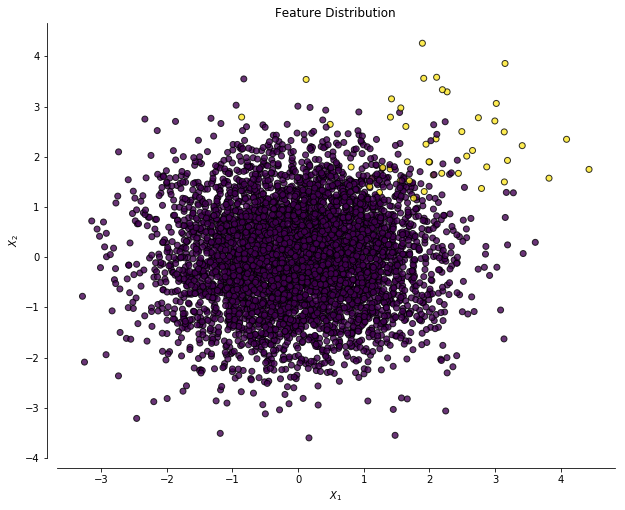

In [77]:
# Random state for reproduceability
seed = 5

# Base rate and sample size
base_rate = 0.01
n = 5000

# Properties of the minority class distribution
mean_minority =  np.array([2,2])
sd_minority = np.array([1,1])
cov_minority = 0

# Majority class parameters
mean_majority = np.array([0,0])
sd_majority = np.array([1,1])
cov_majority = 0

# Make distribution and classes
x, y = make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_minority, mean_majority,
                        sd_majority,cov_majority, random_state = seed)

# Plot
plot_2d(x,y, figsize= (10,8), title= 'Feature Distribution')

The purple points represent the majority class and the yellow points the minority class. Throughout this notebook I will refer to the class of interest as the minority class.

My goal is to build a classifier that predicts the instances of the minority class well. Looking at the distribution, it is easy to see that this is not a simple classification task, independtly of the class imbalance. However it helps to present the issue. I will come back later to the discussion of when class imbalance is an issue in general.

Having simulated the data, I will follow the standard procedure of splitting it into training- and testing-sets, fitting the model on the training set and evaluating the performance on the testing set. Throughout this notebook I'm using `sklearn` and the `LogisticRegression` classifier. By default, this classifier uses either LASSO or ridge regression to identify features. While feature selection can help with class-imbalance issues, I will set the penalty term in the model very low, so that the model uses all features. 

,Accuracy,Precision,Recall
0,0.9932,0.75,0.48


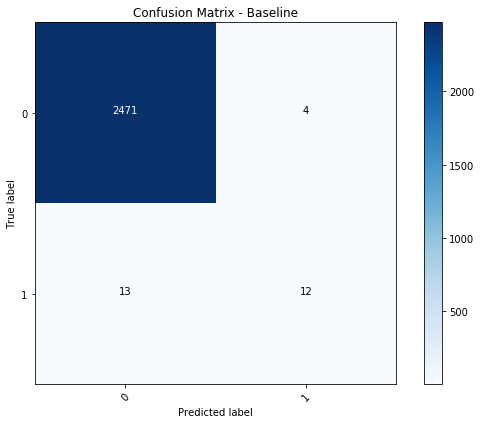

In [78]:
## Train test, split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.5, stratify = y, random_state= 0)

# Instantiate the model, intercept,no class weights (default), C parameter is 1/lambda, 'l1' penalty essentially removed, 
baseline_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model
baseline_model.fit(X_train,y_train);

# Make predictions 
baseline_pred = baseline_model.predict(X_test)

# Get confusion matrix using sklearn metrics
cnf_matrix = metrics.confusion_matrix(y_test,baseline_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Baseline', classes= ['0','1'],figsize=(8,6))

# Get confusion matrix and show scores 
score_model(y_test,baseline_pred)

The above confusion matrix and performance metrics are all calculated on the testing set.

As expected, the resulting classifier has very high, almost perfect, accuracy. However, given that the base-rate was 1 percent, accuracy is not a meaningful metric. The precision matrix shows, that the classifier has correctly classified all but 4 instances of the majority class. However, it has only correctly classified 12 out of 25 instances of the minority class, resulting in a recall of 48 percent. Depending on the task at hand, this could be devastating. If the minority class represents a deadly disease, then the classifier failed to recognize the disease in half of the cases.

In general, assesing the performance and which metric to choose depends on the task at hand. But for the sake of the argument I will follow the disease example in which the classifier should have higher recall.

What did the classifier learn in the end? I will now plot the decision boundary of the logistic regression model to show what the clasifier "learned".

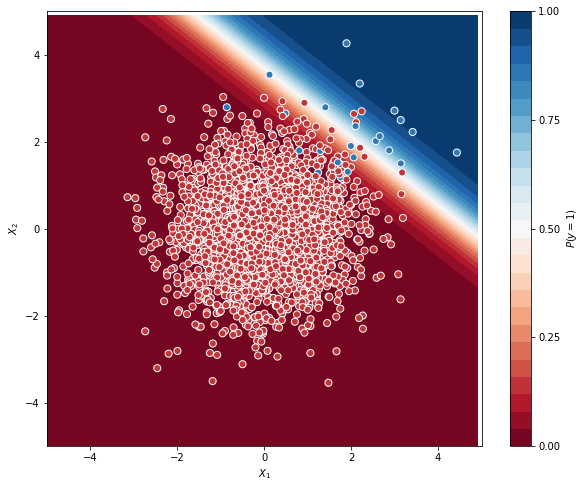

In [79]:
plot_decision_boundary(baseline_model, X_test, y_test,figsize=(10,8))

Recalling, that the feature means of the minority class where at $\mu_{X1} = 2,\mu_{X1} = 2$ and the means of the majority class where $\mu_{X1} = 0,\mu_{X1} = 0$, we can see that the imbalance has shifted decision boundary in favour of the majority class. The outliers of the majority class "conceal" the instances of the minority class in this case. 

Here, a simple solution already appears: Move the decision boundary. In this case a move to a decsision boundary of approx. 0.25 would already capture all minority class instances, as indicated by the ROC curve below. This is of course at the expense of a slightly higher false positive rate.

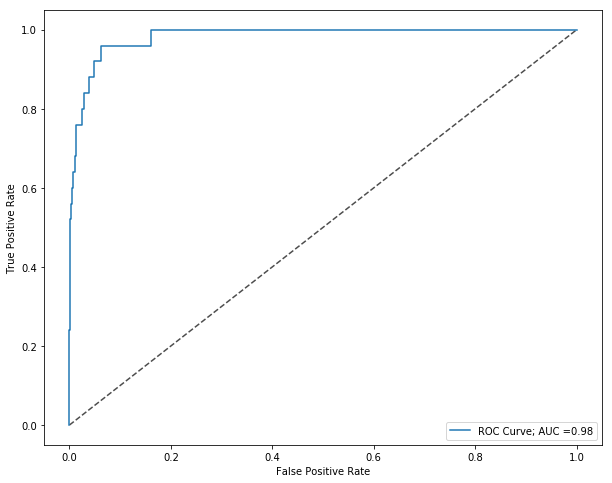

In [73]:
plot_roc_curve(baseline_model, X_test, y_test,figsize= (10,8))


##### Counter Example

I will shortly present a counter example, which still has a high class imbalance, but in which a logistic regression model would still work well.

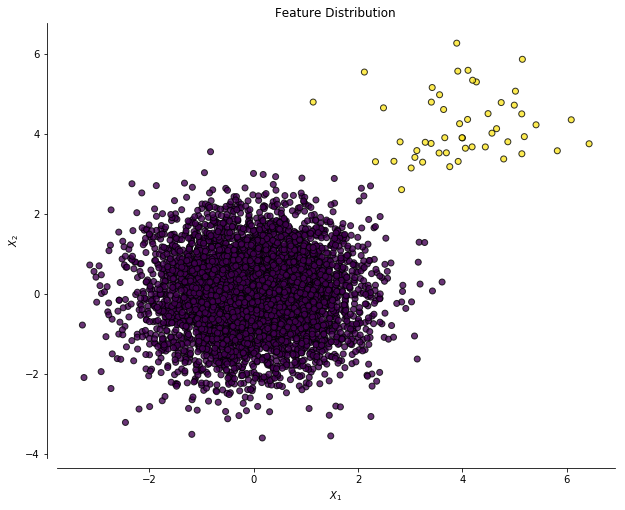

In [9]:
# Base rate and sample size
base_rate = 0.01
n = 5000

# Properties of the minority class distribution
mean_minority =  np.array([4,4])
sd_minority = np.array([1,1])
cov_minority = 0

# Majority class parameters
mean_majority = np.array([0,0])
sd_majority = np.array([1,1])
cov_majority = 0

# Make distribution and classes
x_2, y_2 = make_gaussian_2d(base_rate, n, mean_minority, sd_minority, cov_minority, mean_majority,
                        sd_majority,cov_majority, random_state = seed)


# Plot
plot_2d(x_2,y_2, figsize= (10,8), title= 'Feature Distribution')

The example above has the same base-rate as the previous one. However, due to the larger separation between classes, a classifier would have less of an issue with correctly classifying both cases. 

Having demonstrated the underlying issue, I will now present the previously mentioned sampling techniques for dealing with class imbalances. Throughout the discussion in will continue to work with the previous data set.

#### 3. Sampling Techniques

The general idea behind the use of sampling techniques is to construct a new sample from an imbalanced sample in which the relative frequency of both classes is more balanced. In this way, classifiers should be able to better capture the decision boundary between the majority and minority class **(He & Ma, 20xx)**. 

When using sampling techniques, one has to make sure not to mix up training and testing sets. The sampling technique should be used only on the training set. The performance of the fitted model should then be assessed on a testing set which hasn't been re-sampled. 

##### Correcting for re-sampling

Further, when using logistic regression, one has to correct the resulting model for the differences in relative frequencies of the distribution. Given a classification problem where $Y$ represents the classes and $X$ the features, one tries to find $P(Y \mid X)$. Let's assume that $X$ and $Y$ are from an imbalanced sample, so learning $P(Y \mid X)$ is difficult. Through the use of sampling techniques, one can achieve a balanced sample, where $x$ and $y$ are random variables with joint density $P(x,y)$.  After re-sampling,  $P(x \mid y) = P(X \mid Y)$, but the marginal densities $P ( x ) , P ( y ), P(y \mid x)$ are not equal to $P ( X ) , P ( Y ) ,$ and $P ( Y \mid X )$. However, $P(Y \mid X)$ can now be estimated from $P(x,y)$ using a correction term. To show this assume that $D$ and $d$ are random samples of size $n$ from the joint distributions $P(X,Y)$ and $P(x,y)$. As $n \rightarrow \infty$

$$P ( Y \mid X , D ) = P ( X \mid Y , D ) \frac { P ( Y \mid D ) } { P ( X \mid D ) } \stackrel { d } { \rightarrow } P ( X \mid Y ) \frac { P ( Y ) } { P ( X ) } = P ( Y \mid X )$$

since $P(X \mid D)$ and $P(Y \mid D)$ both converge in distribution to $P(X)$ and $P(Y)$.

However, the same doesn't hold when we estimate $P(y \mid x,d)$, since as $n \rightarrow \infty$ 

$$P ( y \mid x , d ) = P ( x \mid y , d ) \frac{P ( y \mid d )} {P ( x \mid d )}$$

does not converge in distribution to $P(Y \mid X)$ as the marginals differ.  
However, a way to correct for this is by multiplying $P(y \mid x,d)$ with a correction factor. 

$$ P(y \mid x,d) A  B = P ( x \mid y , d ) \frac { P ( y \mid d ) } { P ( x \mid d ) } \frac{P (Y \mid D)} {P(y \mid d)} \frac{P(x \mid d)} {P(X\mid D)} = $$ 



#### 3.1 Under-sampling

One way to achieve a balanced sample is to remove instances from the majority class until a desired sample distribution has been reached. This does not necessarily mean that the sample should be equally balanced. The simplest technique for under-sampling is random under-sampling. In random under-sampling, instances from the majority class are choosen at random and removed **(Hoens and Chawla in He & Ma)**. While this method is fairly easy to implement, one has to be aware that potentially valuable information could be discareded when removing instances **(Hoens and Chawla in He & Ma)**. This is why various extensions to random under-sampling have been developed, such as removing instances based on clustering methods. These methods try to identify _redundant_ or _noisy_ instances in the data.



For the following discussion I will present the random under-sampling method using the `imblearn` library. 

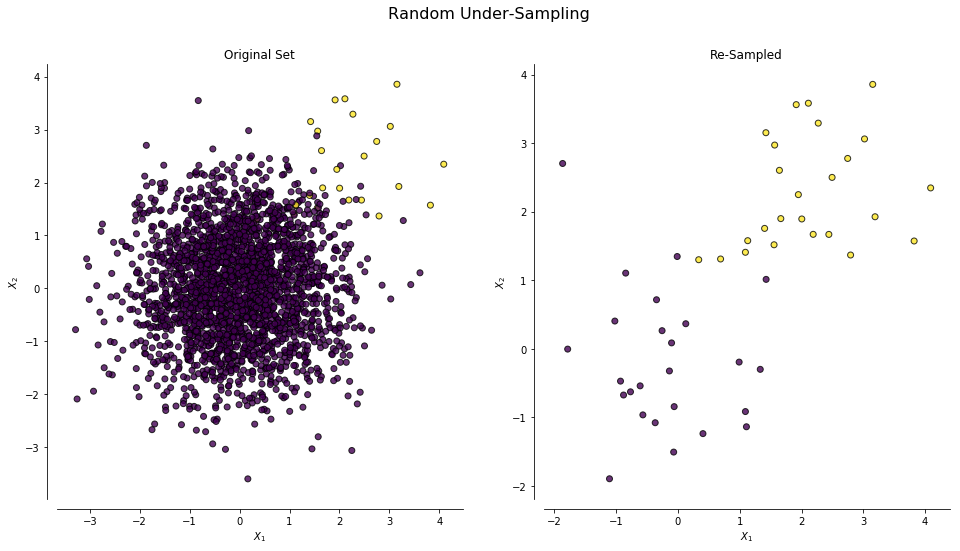

In [10]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate the sampler
rus = RandomUnderSampler(sampling_strategy=1, random_state=2)

X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)
plot_resample(X_train,y_train,X_train_undersampled,y_train_undersampled,title = 'Random Under-Sampling')

- Using random under-sampling to get a "balanced" sample
- Naive approach removes instances from the majority class completly random
- What does this do to perforamance?
- Fit a new classifier, makes comparison easier
- Note: The fact, that the split is "perfect" is due to randomness!

Correction for sampling method:
- Discuss here 

,Accuracy,Precision,Recall
0,0.986,0.380952,0.64


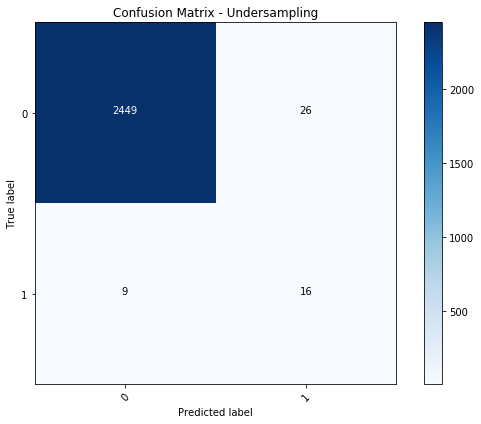

In [11]:
# Instantiate the model, intercept,no class weights (default), 'l1' penalty essentially removed
undersampled_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model
undersampled_model.fit(X_train_undersampled,y_train_undersampled);

# Correction the intercept
correct_intercept_logit(undersampled_model, y_train, y_train_undersampled)

# Now make predictions
undersample_pred = undersampled_model.predict(X_test)

# Get confusion matrix using sklearn metrics
cnf_matrix = metrics.confusion_matrix(y_test,undersample_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Undersampling', classes= ['0','1'],figsize=(8,6))

# Get confusion matrix and show scores 
score_model(y_test,undersample_pred)

- Precision went down compared to previous case, classifier predicts more false positives
- Recall is now a lot better, this is kind of what we wanted!
- Shows a trade-off between the two!
- Prediction for the 1 class has significantly improved!
- More false positive predictions, but relative to true negative predictions very low
- Would also need to take into account, that these are rare cases of the majority class

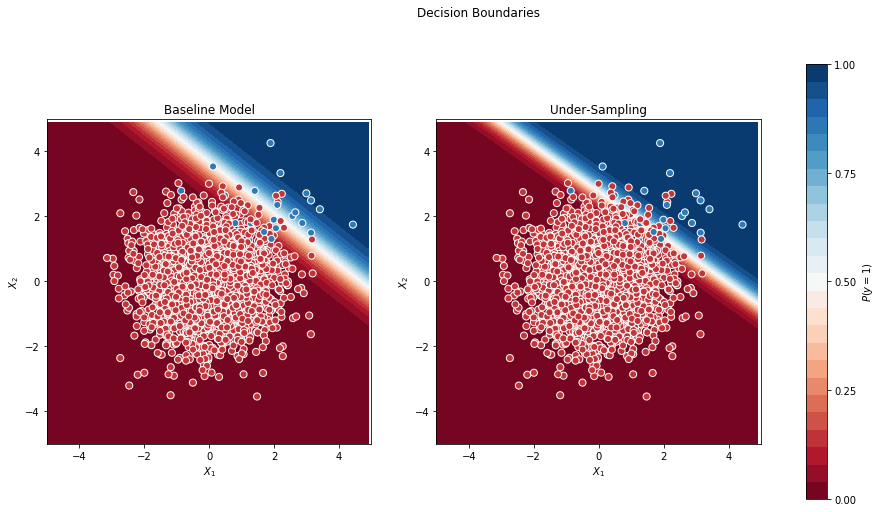

In [12]:
# Compare resulting decsision boundaries
plot_decision_resample([baseline_model,undersampled_model],X_test,y_test, titles= ['Baseline Model', 'Under-Sampling'])

- Striking difference in the decsision boundary
- Boundary is now "sharper",
- We can see the effect on precision and recall, more instances of the majority class are now being classified as 1

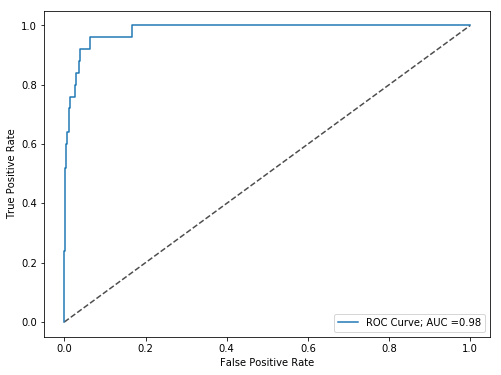

In [13]:
plot_roc_curve(undersampled_model, X_test, y_test)

- ROC curve no difference!

### Random Over-Sampling

Random over sampling
- Copy and repeat the minority class instances until desired level of balance is achieved (Hoens and Chawla in He & Ma)
- Here also "smart" extensions, one of them generating synthetic examples sing SMOTE (cite) or ADASYN (cite), will be discussed later
- Potential drawbacks: Strong overfitting, classifier will have a hard time to generalize (Hoens and Chawla in He & Ma)

Hybrids of both methods are possible, will later discuss generation of synthetic samples.

- Now present under- and oversampling



- Now use random over-sampling
- Follow same strategy as for under-sampling, but now repeat instances of the minority class instead of removing instances of majority class
- Also make a 50/50 balanced sample

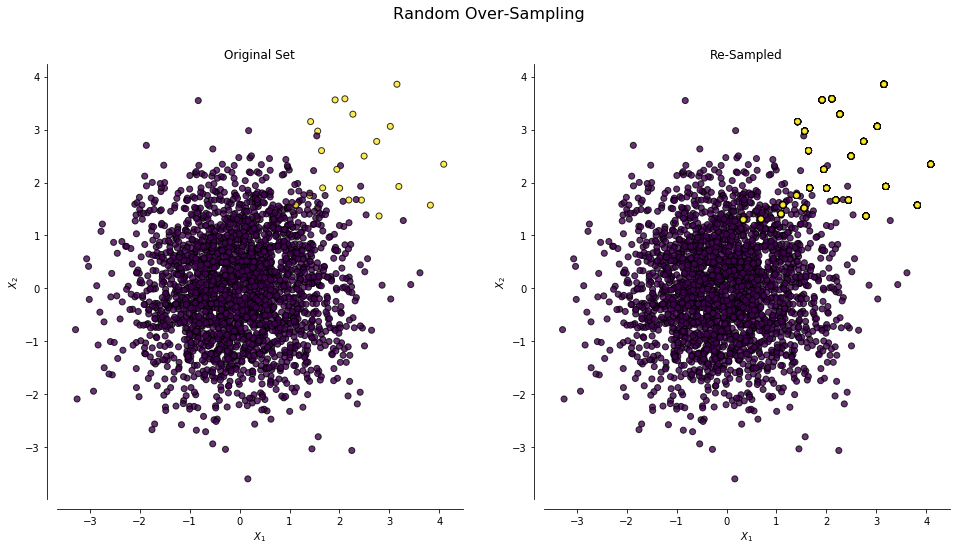

In [14]:
from imblearn.over_sampling import RandomOverSampler
random_oversampler = RandomOverSampler(sampling_strategy = 1,random_state=0)
X_train_oversampled, y_train_oversampled = random_oversampler.fit_resample(X_train, y_train)

plot_resample(X_train,y_train,X_train_oversampled,y_train_oversampled,title = 'Random Over-Sampling')

- Difference hard to see now, but one can slightly see the that the "thickness" of the circles of the minority class has increased
- this is due to the fact, that every minority class sample has now been repeated X times!
- sample is also balanced now!

,Accuracy,Precision,Recall
0,0.9928,0.684211,0.52


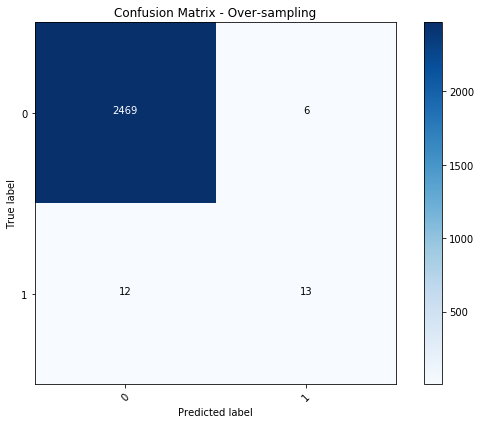

In [15]:
# Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
oversampled_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model 
oversampled_model.fit(X_train_oversampled, y_train_oversampled );

# Correct the intercept 
correct_intercept_logit(oversampled_model, y_train, y_train_oversampled)

# Make predictions on testing values
oversample_pred = oversampled_model.predict(X_test)

# Get confusion matrix using sklearn metrics
cnf_matrix = metrics.confusion_matrix(y_test,oversample_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Over-sampling', classes= ['0','1'],figsize=(8,6))

# Get confusion matrix and show scores 
score_model(y_test,oversample_pred)

- Performance out of sample did not improve massively
- Maybe due to overfitting, check the decsision boundary

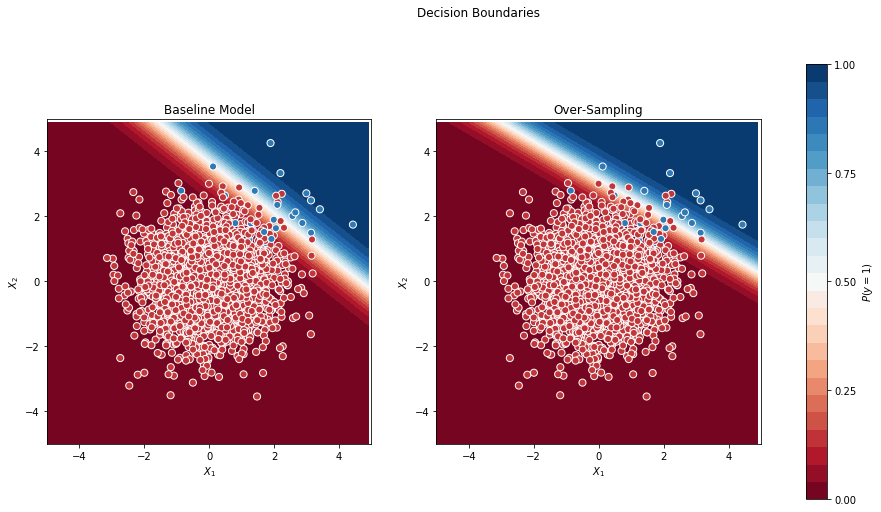

In [16]:
# Compare resulting decsision boundaries
plot_decision_resample([baseline_model,oversampled_model],X_test,y_test, titles= ['Baseline Model', 'Over-Sampling'])

- Eyeballing the boundaries, not much changed, which is kind of in line with prediction performance
- Reasons ? Bias variance trade-off? 
- Let's see the performance in sample and the decsision boundary in sample

,Accuracy,Precision,Recall
0,0.994,0.777778,0.56


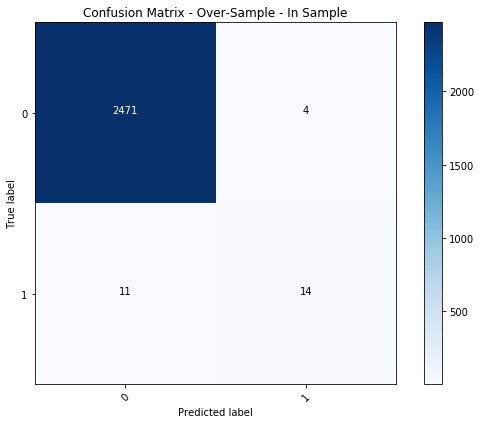

In [17]:
# Make predictions on testing values
oversample_pred_insample = oversampled_model.predict(X_train)

# Get confusion matrix using sklearn metrics (now in-sample)
cnf_matrix = metrics.confusion_matrix(y_train,oversample_pred_insample)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Over-Sample - In Sample', classes= ['0','1'],figsize=(8,6))

# Get scores 
score_model(y_train,oversample_pred_insample)

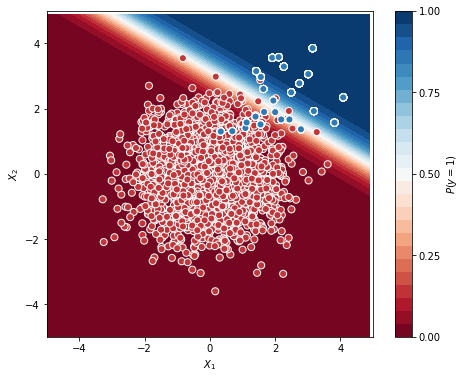

In [18]:
# Compare resulting decsision boundaries
plot_decision_boundary(oversampled_model,X_train_oversampled,y_train_oversampled)

- What do we see? 
- Oversampling didn't help that much, due to the distribution of the points?
- Discuss a bit more here

### SMOTE Chawla et al (2002)

#### Previous Work: Imbalanced datasets 
- Kubat and Matwin (1997) selectively under-sample the majority class while keeping the original population of the minority class
- Minority examples were divided into four categories: Some noise overlapping the positive class descision regon, borderline samples, redundant samples and safe samples
- Ling and Li (1998): Combine over-sampling the minority class with under-sampling the majority class
- used lift analysis instead of accuracy
- lift curve is more similar to an ROC curve, but more tailored to marketing
- Solberg and Solberg (1996): Oil-slick classification, balance 50-50, achieved 14% error rate on the interesting samples and 4 % error on the "negative" samples
- Precision and recall

*Literature summary: Under-sampling the majority class enables better classifiers to be built than over-sampling the minority class!*
-> Very interesting summary, check?
- Combination of the two as done in previous work does not lead to classifiers that outperform those built with undersampling of majority
- Oversampling of the minority class has been donw by sampling with replacement from the original data, this might be an issue -> SMOTE

#### SMOTE

- Previous research discussed over-sampling with replacment and showed that it doesn't significantly improve minority class recognition
- Authors argue with underlying effect in terms of descision region feature space
- As the minority class is over-sampled by increasing amounts, the effect is to identify similar but more specific regions in the feature space as the descision region for the minority class

Understanding over- and undersampling in terms of descision regions
-> Descision boundary for linear regression?

- Propose an over-sampling approach in which the minority class is over-sampled by creating synthetic examples, rather than oversampling with replacement
- Inspired by handwriting recognition: Used real pictures and perturbed the data a bit to generate new samples
- Generate synthetic examples by operating in "feature space" not "data space"
- Taking each minority class sample, introducing synthetic examples along the line segments, joining any / all of the k-miniority class nearest neighbors
- Samples are generated by taking the difference between the feature vector (sample) under consideration and it's nearest neighbor.
- Multiply this difference by a random number between 0 and 1, add it to the feature vector under consideration
- Causes the selection of a random point along the line segment between two specific features
- Forces the decision region of the minority class to become more general
- The amount of over-sampling is a parameter of the system, series of ROC curves can be generated for different populations and ROC analysis performed

- Synthetic samples cause the classifier to create larger and less specific decision regions, rather than smaller and more specific regions
- Better for decision trees?

##### Under-sampling and SMOTE Combination
- Majority class under-sampled, by randomly removing samples until the minority class becomes some specififed percentage of the majority class
- Forces the learner to experience varying degrees of under-sampling
- By applying a combination of under-sampling and over-sampling, the inital bias of the learner is reversed in favor of the minority class
- This is a crucial but somewhat overlooked part of the paper! 
- The best performance is reached when combining SMOTE and under-sampling of the majority class

> Combination of SMOTE and under-sampling is the way to go according to the authors

- Will no apply SMOTE using the imbalanced learn library

SMOTE using 5 nearest neighbtors, and trying to achieve a balanced sample with 50/50 distribution

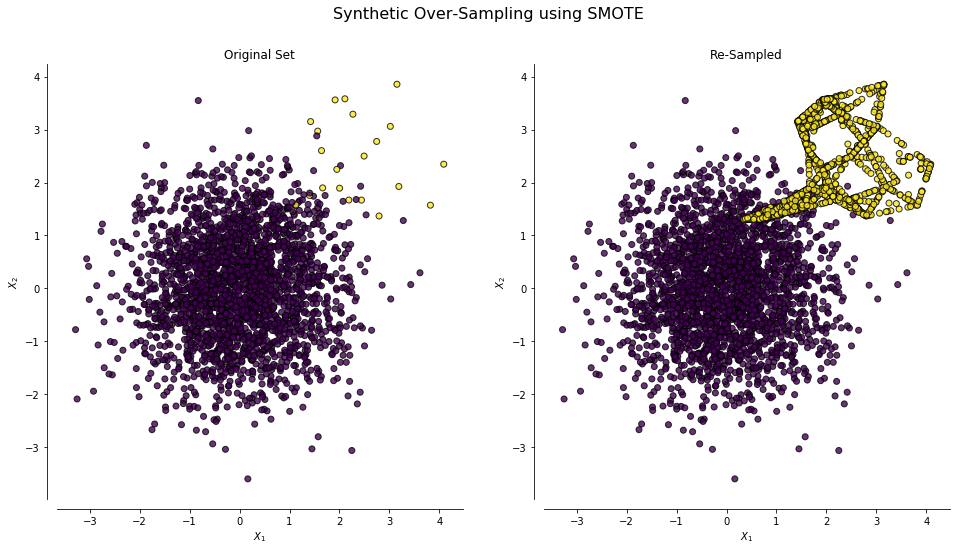

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors=5 ,sampling_strategy= 0.5, random_state= 0)

# Use smote to resample
X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)

plot_resample(X_train,y_train, X_train_smote,y_train_smote, title='Synthetic Over-Sampling using SMOTE')

- Can see, that instead of resampling the same instances over and over again, smote produces "new" instances
- Somewhat evenly spaced 
- Makes actually an "odd" looking distribution
- Now assess the performance of the model trained on the "smoted" dataset
- Discuss the "look" a bit more

,Accuracy,Precision,Recall
0,0.9924,0.65,0.52


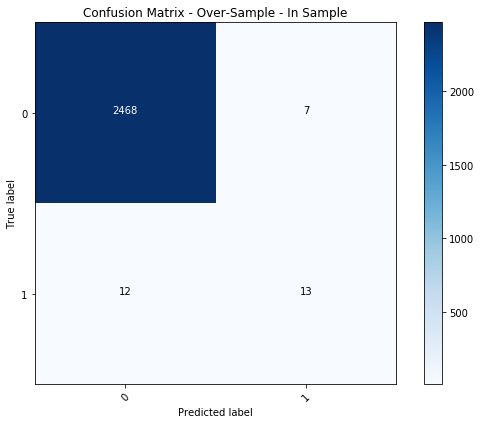

In [22]:
# Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
smote_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model 
smote_model.fit(X_train_smote, y_train_smote);

# Correct the intercept 
correct_intercept_logit(smote_model, y_train, y_train_smote)

# Make predictions on testing values
smote_pred = smote_model.predict(X_test)

# Get confusion matrix using sklearn metrics (now in-sample)
cnf_matrix = metrics.confusion_matrix(y_test,smote_pred)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - Over-Sample - In Sample', classes= ['0','1'],figsize=(8,6))

# Get scores 
score_model(y_test,smote_pred)

- Performance improved slightly, but not significantly
- Recall slightly better than baseline model
- Precision dropped
- Accuracy similar
- Recall lower than undersampling
- Overall performance comparable to simple over-sampling!
- How has the decsision boundary been influenced?

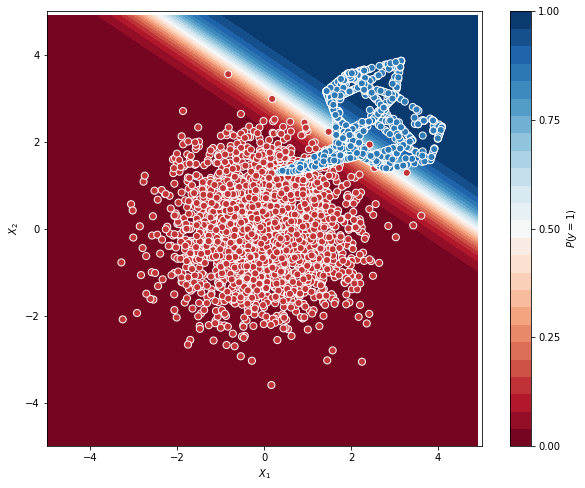

In [23]:
# Decision boundary and training data for SMOTE
plot_decision_boundary(smote_model,X_train_smote,y_train_smote, figsize=(10,8))

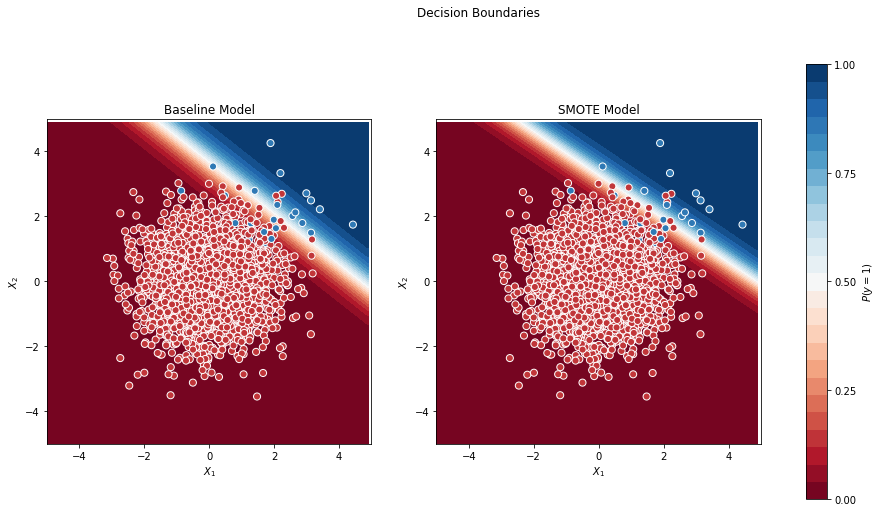

In [24]:
plot_decision_resample([baseline_model,smote_model],X_test, y_test,titles=['Baseline Model', 'SMOTE Model'])

- Shift is hard to gauge visually
- Slightly narrower decision boundary

##### SMOTE with random undersampling
- since authors mentioned it, will also test smote with random under-sampling and compare to other methods
- I somehow assume, that the reason smote works is not smote but the under-sampling!
- I will later run simulations to verify all my findings empirically!
- Have to make custom helper function to under-sample
- Imbalance learn can't completly undersample!

In [25]:
# Helper function for making an imbalance 
def custom_random_undersample(strategy, X_train,y_train):
    
    # Make column names
    names = ['X'+str(nr) for nr in range(0,X_train.shape[1])]

    # Store data in data frame
    df = pd.DataFrame.from_records(X_train, columns= names)
    
    # Add class column
    df['Class'] = y_train
    
    # Nr. Negative Class instances
    n_negative = len(df[df.Class == 0])

    # Nr. Postive Class Instances
    n_positive = len(df[df.Class == 1])
    
    # Get number of instances that should be removed (has to be integer)
    remove_n = int(n_negative - (strategy / (1-strategy)) * n_positive)
 
    # Get random indices from the majority class which have to be removed
    drop_indices = np.random.choice(df[df.Class == 0].index, remove_n, replace=False)

    # Get resampled pd
    resampled_pd = df.drop(drop_indices)

    # Transform to arrays and return
    X_resample = np.array(resampled_pd.loc[:, resampled_pd.columns != 'Class'])
    y_resample = np.array(resampled_pd.loc[:, resampled_pd.columns == 'Class']).ravel()

    return X_resample, y_resample

# Custom SMOTE undersample function 
def smote_undersampler(smote,strategy,X_train,y_train):
    
    # Use smote to resample
    X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)
    
    # Use custom undersampler to undersample the resulting model
    X_train_smote_undersampled, y_train_smote_undersampled = custom_random_undersample(strategy
                                                                                       ,X_train_smote, 
                                                                                       y_train_smote)
    
    # Return
    return X_train_smote_undersampled, y_train_smote_undersampled
    

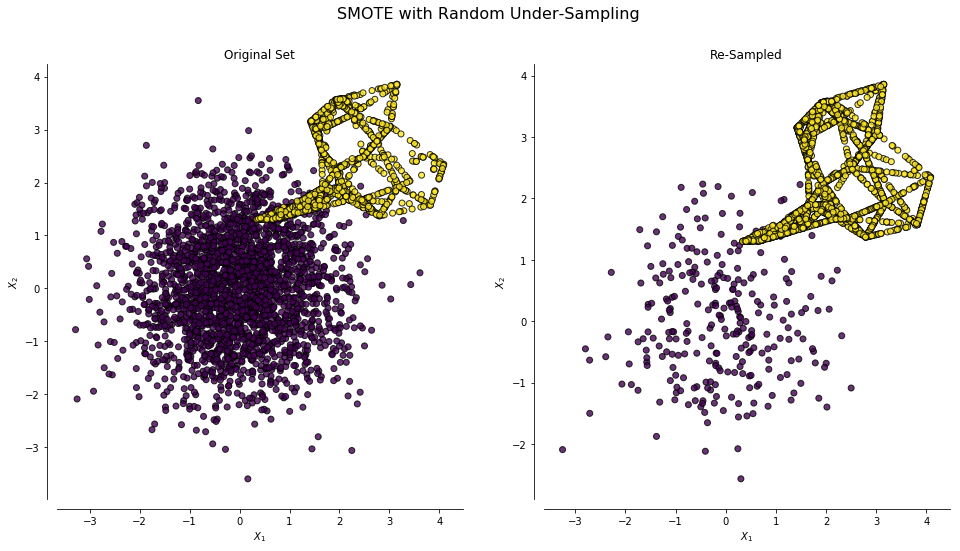

In [26]:
smote = SMOTE(k_neighbors=5 ,sampling_strategy= 1)
X_train_smote_undersampled,y_train_smote_undersampled = smote_undersampler(smote, strategy= 0.1, X_train = X_train,y_train = y_train)
plot_resample(X_train_smote,y_train_smote,X_train_smote_undersampled, y_train_smote_undersampled, 
              title= 'SMOTE with Random Under-Sampling')

,Accuracy,Precision,Recall
0,0.9896,0.482759,0.56


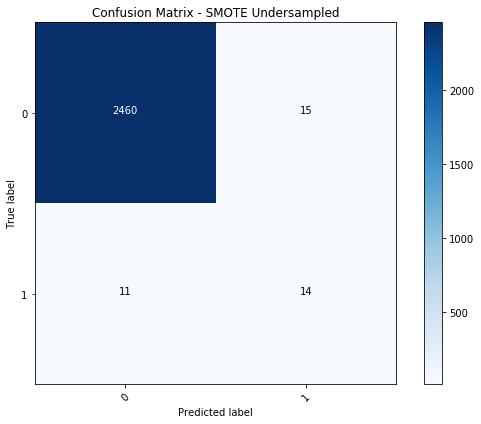

In [27]:
#Instantiate the model, very small penalty, intercept, 10-Fold Cv, no class weights (default)
smote_under_model = LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Fit the model 
smote_under_model.fit(X_train_smote_undersampled, y_train_smote_undersampled);

# Correct the intercept 
correct_intercept_logit(smote_under_model, y_train, y_train_smote_undersampled)

# Make predictions on testing values
smote_pred_under = smote_under_model.predict(X_test)

# Get confusion matrix using sklearn metrics (now in-sample)
cnf_matrix = metrics.confusion_matrix(y_test,smote_pred_under)

# Plot the confusion matrix
plot_confusion(cnf_matrix, title= 'Confusion Matrix - SMOTE Undersampled', classes= ['0','1'],figsize=(8,6))

# Get scores 
score_model(y_test,smote_pred_under)

- Better recall then SMOTE alone, precsision dropped
- Recall slightly improved
- Overall no improvement compared to plain undersampling.

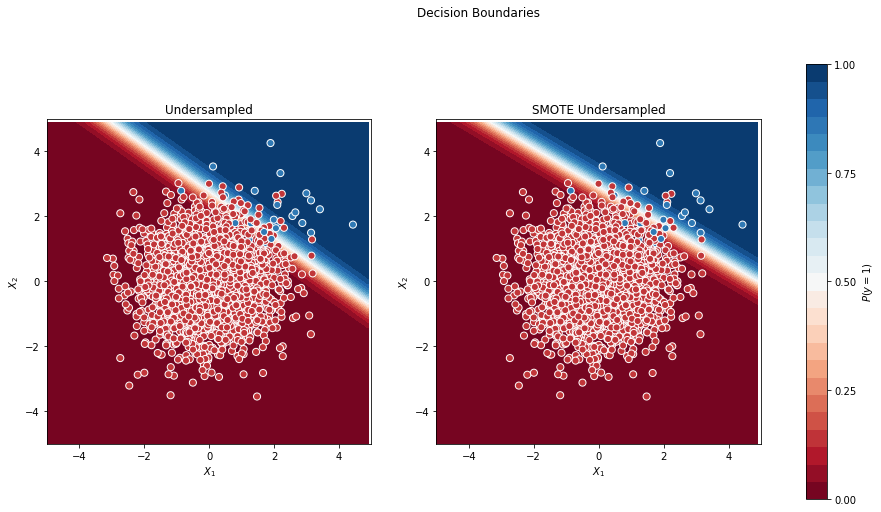

In [28]:
plot_decision_resample([undersampled_model, smote_under_model],X_test, y_test, titles= ['Undersampled','SMOTE Undersampled'])

- Decsision boundary again "sharper"
- But no clear reason as to why use SMOTE and not just under-sampling?
- Will now try to shed some ligth on the usefulness of various methods

#### Simulation

- Now that I've demonstrated the basic ideas behind all methods, time to make simulations in higher dimensions
- I'm primarily interested in what drives the performance of each sampling method and when / how which method stands out

#### Different base sampling techniques at different base rates

- Simulate 100 random classification problems (gaussian feautres) at different base rates
- Store metrics
- Compare

In [63]:
# Instantiate the model, always the same model it's just going to be refit every time
model =  LogisticRegression(C = 1e5,solver='liblinear', max_iter= 100, fit_intercept= True, penalty= 'l1')

# Instantiate all samplers, smote_undersampler is a function of smote
undersampler = RandomUnderSampler(sampling_strategy=1)
oversampler = RandomOverSampler(sampling_strategy=1)
smote = SMOTE(k_neighbors=5,sampling_strategy=1)


if simulate:
    
    # takes about 30 mins 

    # Ignore warnings, these would occur from precision 0
    import warnings
    warnings.filterwarnings("ignore")

    # Strategy names for result df columns
    strat_names =  ['Baseline', 'Undersampling', 'Oversampling','SMOTE', 'SMOTE Undersampling']

    # Number of total samples in each simulation
    n = 2000

    # Number of simulations per sample
    n_simulations = 500

    # Lists to store results for every base rate level, will be turned into result data-frames
    avg_accuracy = []
    avg_precision = []
    avg_recall = []
    avg_auc = []

    # Different base rates
    rates = np.linspace(0.01,0.05,5)

    # Simulate n_simulations at every base rate and take average metrics
    for base_rate in rates:
    
        # Get current weights of the classes, first class is the majority class, second the one of interest.
        weights = [1-base_rate,base_rate]
    
        # Temporary lists to store results in
        accuracy_list = []
        precision_list = []
        recall_list = []
        auc_list = []
    
        # Simulate at current base rate
        for i in range(0,n_simulations):
        

            # Make a new dataset
            x,y = make_classification(n_samples=n, n_features=20,
                                   n_informative=10, n_redundant=0, n_repeated=0,
                                   n_classes=2,
                                   n_clusters_per_class=1,
                                   weights=list(weights),
                                   class_sep=0.5, flip_y = 0)
    
            # Train-test-split, stratified
            X_train , X_test, y_train, y_test = train_test_split(x,y, test_size = 0.5, stratify = y)
        
            # Sample Fit metrics for all different strategies
        
            # Baseline
            acc_base, prec_base, rec_base, auc_base = sample_fit_metrics(model,X_train , 
                                                                X_test, y_train, y_test,sampler= None)
    
            # Undersampling
            acc_under, prec_under, rec_under, auc_under= sample_fit_metrics(model,X_train, X_test, y_train, y_test, 
                                                                                   sampler = undersampler)
            # Oversampling  
            acc_over, prec_over, rec_over, auc_over= sample_fit_metrics(model,X_train , X_test, 
                                                                y_train, y_test, sampler = oversampler)
    
            # SMOTE
            acc_smote, prec_smote, rec_smote, auc_smote =sample_fit_metrics(model,X_train , X_test, 
                                                                y_train, y_test, sampler = smote)
            # SMOTE with undersampling
            acc_smote_u, prec_smote_u, rec_smote_u, auc_smote_u= sample_fit_metrics(model,X_train, X_test, 
                                                                                    y_train, y_test, 
                                                                            sampler = smote_undersampler)
    
            # Store values in lists
            accuracy_list.append([acc_base,acc_under,acc_over,acc_smote,acc_smote_u])
            precision_list.append([prec_base,prec_under,prec_over,prec_smote,prec_smote_u])
            recall_list.append([rec_base,rec_under,rec_over,rec_smote,rec_smote_u])
            auc_list.append([auc_base,auc_under,auc_over,auc_smote,auc_smote_u])
    
        # Store averages in lists 
        avg_accuracy.append(pd.DataFrame.from_records(accuracy_list,columns=strat_names).mean().values)
        avg_precision.append(pd.DataFrame.from_records(precision_list,columns=strat_names).mean().values)
        avg_recall.append(pd.DataFrame.from_records(recall_list,columns=strat_names).mean().values)
        avg_auc.append(pd.DataFrame.from_records(auc_list,columns=strat_names).mean().values)

    # Make summary data frames for all rates
    accuracy_pd = pd.DataFrame.from_records(avg_accuracy,columns= strat_names, index = rates)
    precision_pd = pd.DataFrame.from_records(avg_precision, columns=strat_names, index = rates)
    recall_pd = pd.DataFrame.from_records(avg_recall, columns=strat_names, index = rates)
    auc_pd = pd.DataFrame.from_records(avg_auc, columns=strat_names, index = rates)
    
    if save:
        accuracy_pd.to_csv(filepath+'Accuracy_Base_Rates.csv')
        precision_pd.to_csv(filepath+'Precision_Base_Rates.csv')
        recall_pd.to_csv(filepath+'Recall_Base_Rates.csv')
        auc_pd.to_csv(filepath+'AUC_Base_Rates.csv')
    
else:
    accuracy_pd = pd.read_csv(filepath+'Accuracy_Base_Rates.csv', index_col= 0)
    precision_pd = pd.read_csv(filepath+'Precision_Base_Rates.csv',index_col = 0)
    recall_pd = pd.read_csv(filepath+'Recall_Base_Rates.csv', index_col = 0 )
    auc_pd = pd.read_csv(filepath+'AUC_Base_Rates.csv', index_col = 0)

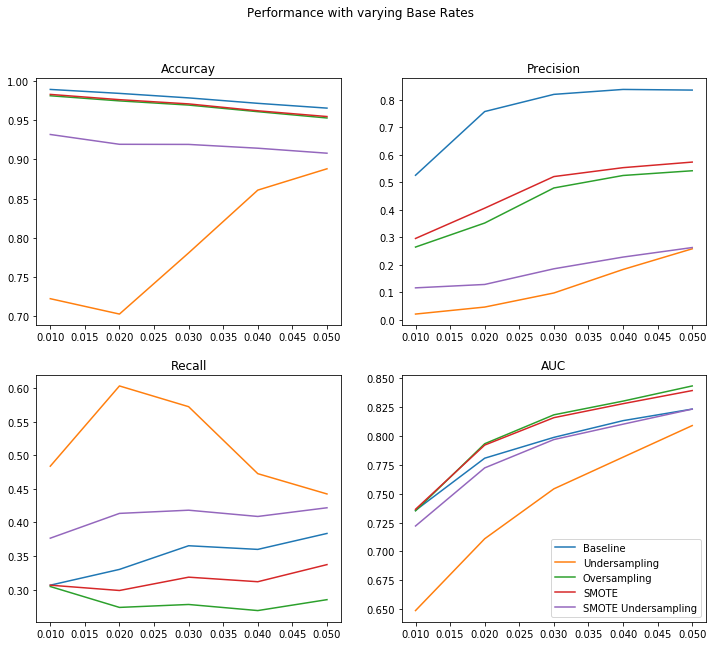

In [52]:
# Plot setting
plt.rcParams['figure.figsize'] = (10,8)

# Plot results
plot_results(accuracy_pd,precision_pd,recall_pd,auc_pd, title = 'Performance with varying Base Rates')

- Accuracy always lower than baseline, this is obvious
- Precision also always lower
- Recall is improved for undersampling and smote with undersampling, however, for these two the trade-off with precision is also the largest!
- AUC for these two are also smaller than for the others, AUC for Oversampling and basic SMOTE are the best indepentent of baseline

#### Different sampling techniques at different class separations with base rate 0.01

- Simulate 100 random classification problems (gaussian feautres) at different seperations, base rate constant at 1%
- Store metrics
- Compare

In [53]:
if simulate:
    
    # Takes about 30 mins
   
    # Different base rates
    base_rate = 0.01

    # Get current weights of the classes, first class is the majority class, second the one of interest.
    weights = [1-base_rate,base_rate]

    # Lists to store results for every base rate level, will be turned into result data-frames
    avg_accuracy = []
    avg_precision = []
    avg_recall = []
    avg_auc = []

    # Levels of seperation
    separations = np.linspace(0.1,1,10)

    # Number of simulations per sample
    n_simulations = 500

    # Simulate n_simulations at every base rate and take average metrics
    for sep in separations:
        print('Current separation:' + str(sep))
    
        # Temporary lists to store results in
        accuracy_list = []
        precision_list = []
        recall_list = []
        auc_list = []
    
        # Simulate at current base rate
        for i in range(0,n_simulations):
        
            # Make a new dataset
            x,y = make_classification(n_samples=n, n_features=20,
                                   n_informative=10, n_redundant=0, n_repeated=0,
                                   n_classes=2,
                                   n_clusters_per_class=1,
                                   weights=list(weights),
                                   class_sep=sep, flip_y = 0)
    
            # Train-test-split, stratified
            X_train , X_test, y_train, y_test = train_test_split(x,y, test_size = 0.5, stratify = y)
        
            # Sample Fit metrics for all different strategies
        
            # Baseline
            acc_base, prec_base, rec_base, auc_base = sample_fit_metrics(model,X_train , 
                                                                X_test, y_train, y_test,sampler= None)
    
            # Undersampling
            acc_under, prec_under, rec_under, auc_under= sample_fit_metrics(model,X_train, X_test, y_train, y_test, 
                                                                                   sampler = undersampler)
            # Oversampling  
            acc_over, prec_over, rec_over, auc_over= sample_fit_metrics(model,X_train , X_test, 
                                                                    y_train, y_test, sampler = oversampler)
    
            # SMOTE
            acc_smote, prec_smote, rec_smote, auc_smote =sample_fit_metrics(model,X_train , X_test, 
                                                                y_train, y_test, sampler = smote)
            # SMOTE with undersampling
            acc_smote_u, prec_smote_u, rec_smote_u, auc_smote_u= sample_fit_metrics(model,X_train, X_test, y_train, y_test, 
                                                                            sampler = smote_undersampler)
    
            # Store values in lists
            accuracy_list.append([acc_base,acc_under,acc_over,acc_smote,acc_smote_u])
            precision_list.append([prec_base,prec_under,prec_over,prec_smote,prec_smote_u])
            recall_list.append([rec_base,rec_under,rec_over,rec_smote,rec_smote_u])
            auc_list.append([auc_base,auc_under,auc_over,auc_smote,auc_smote_u])
    
        # Store averages in lists 
        avg_accuracy.append(pd.DataFrame.from_records(accuracy_list,columns=strat_names).mean().values)
        avg_precision.append(pd.DataFrame.from_records(precision_list,columns=strat_names).mean().values)
        avg_recall.append(pd.DataFrame.from_records(recall_list,columns=strat_names).mean().values)
        avg_auc.append(pd.DataFrame.from_records(auc_list,columns=strat_names).mean().values)

    # Make summary data frames for all rates
    accuracy_pd_sep = pd.DataFrame.from_records(avg_accuracy,columns= strat_names, index = seperations)
    precision_pd_sep = pd.DataFrame.from_records(avg_precision, columns=strat_names, index = seperations)
    recall_pd_sep = pd.DataFrame.from_records(avg_recall, columns=strat_names, index = seperations)
    auc_pd_sep = pd.DataFrame.from_records(avg_auc, columns=strat_names, index = seperations)
    
    if save:
        accuracy_pd_sep.to_csv(filepath+'accuracy_pd_sep.csv')
        precision_pd_sep.to_csv(filepath+'precision_pd_sep.csv')
        recall_pd_sep.to_csv(filepath+'recall_pd_sep.csv')
        auc_pd_sep.to_csv(filepath+'auc_pd_sep.csv')
        
else:
    accuracy_pd_sep = pd.read_csv(filepath+'accuracy_pd_sep.csv', index_col= 0)
    precision_pd_sep = pd.read_csv(filepath+'precision_pd_sep.csv', index_col=0)
    recall_pd_sep = pd.read_csv(filepath+'recall_pd_sep.csv', index_col=0)
    auc_pd_sep = pd.read_csv(filepath+'auc_pd_sep.csv',index_col=0)

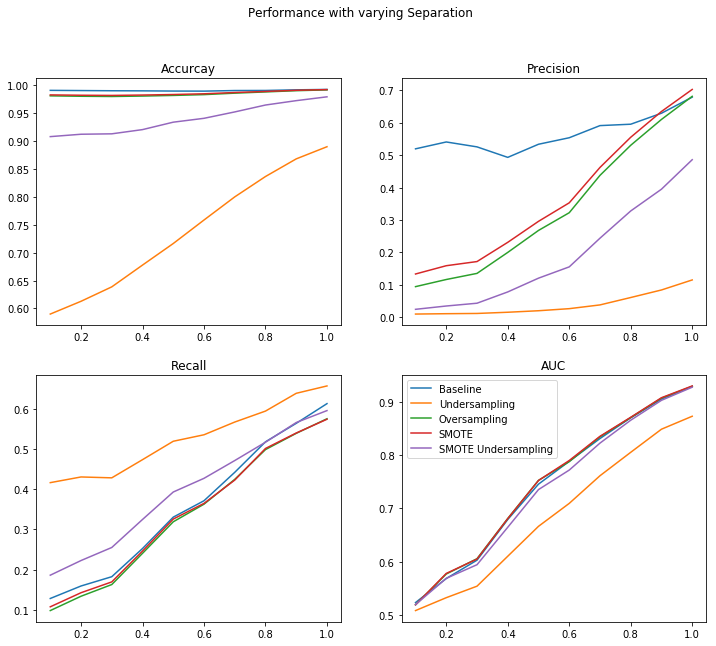

In [54]:
# Plot results
plot_results(accuracy_pd_sep,precision_pd_sep,recall_pd_sep,auc_pd_sep, title = 'Performance with varying Separation')

#### Nr of informative features, base rate 0.01, separation 0.4

In [64]:
if simulate:

    # Takes about an hour
        
    # Base rate
    base_rate = 0.01

    # Get current weights of the classes, first class is the majority class, second the one of interest.
    weights = [1-base_rate,base_rate]

    # Lists to store results for every base rate level, will be turned into result data-frames
    avg_accuracy = []
    avg_precision = []
    avg_recall = []
    avg_auc = []

    # Nr of informative features (out of 20)
    nr_informative_features = np.linspace(1,20,20)

    # Number of simulations per sample
    n_simulations = 500

    # Simulate n_simulations at every base rate and take average metrics
    for inf_features in nr_informative_features:
        print('Current nr of features:' + str(inf_features))
    
        # Temporary lists to store results in
        accuracy_list = []
        precision_list = []
        recall_list = []
        auc_list = []
    
        # Simulate at current base rate
        for i in range(0,n_simulations):
        
            # Make a new dataset
            x,y = make_classification(n_samples=n, n_features=20,
                                   n_informative= int(inf_features), n_redundant=0, n_repeated=0,
                                   n_classes=2,
                                   n_clusters_per_class=1,
                                   weights=list(weights),
                                   class_sep=0.6, flip_y = 0)
    
            # Train-test-split, stratified
            X_train , X_test, y_train, y_test = train_test_split(x,y, test_size = 0.5, stratify = y)
        
            # Sample Fit metrics for all different strategies
        
            # Baseline
            acc_base, prec_base, rec_base, auc_base = sample_fit_metrics(model,X_train , 
                                                                X_test, y_train, y_test,sampler= None)
    
            # Undersampling
            acc_under, prec_under, rec_under, auc_under= sample_fit_metrics(model,X_train, X_test, y_train, y_test, 
                                                                                   sampler = undersampler)
            # Oversampling  
            acc_over, prec_over, rec_over, auc_over= sample_fit_metrics(model,X_train , X_test, 
                                                                y_train, y_test, sampler = oversampler)
    
            # SMOTE
            acc_smote, prec_smote, rec_smote, auc_smote =sample_fit_metrics(model,X_train , X_test, 
                                                                y_train, y_test, sampler = smote)
            # SMOTE with undersampling
            acc_smote_u, prec_smote_u, rec_smote_u, auc_smote_u= sample_fit_metrics(model,X_train, X_test,
                                                                                    y_train, y_test, 
                                                                            sampler = smote_undersampler)
    
            # Store values in lists
            accuracy_list.append([acc_base,acc_under,acc_over,acc_smote,acc_smote_u])
            precision_list.append([prec_base,prec_under,prec_over,prec_smote,prec_smote_u])
            recall_list.append([rec_base,rec_under,rec_over,rec_smote,rec_smote_u])
            auc_list.append([auc_base,auc_under,auc_over,auc_smote,auc_smote_u])
    
        # Store averages in lists 
        avg_accuracy.append(pd.DataFrame.from_records(accuracy_list,columns=strat_names).mean().values)
        avg_precision.append(pd.DataFrame.from_records(precision_list,columns=strat_names).mean().values)
        avg_recall.append(pd.DataFrame.from_records(recall_list,columns=strat_names).mean().values)
        avg_auc.append(pd.DataFrame.from_records(auc_list,columns=strat_names).mean().values)

    # Make summary data frames for all rates
    accuracy_pd_features = pd.DataFrame.from_records(avg_accuracy,columns= strat_names, index = nr_informative_features)
    precision_pd_features = pd.DataFrame.from_records(avg_precision, columns=strat_names, index = nr_informative_features)
    recall_pd_features = pd.DataFrame.from_records(avg_recall, columns=strat_names, index = nr_informative_features)
    auc_pd_features = pd.DataFrame.from_records(avg_auc, columns=strat_names, index = nr_informative_features)
    
    if save:
        accuracy_pd_features.to_csv(filepath+'accuracy_pd_features.csv')
        precision_pd_features.to_csv(filepath+'precision_pd_features.csv')
        recall_pd_features.to_csv(filepath+'recall_pd_features.csv')
        auc_pd_features.to_csv(filepath+'auc_pd_features.csv')
        
        
# Else load the stored simulations
else:
    accuracy_pd_features = pd.read_csv(filepath+'accuracy_pd_features.csv', index_col=0)
    precision_pd_features = pd.read_csv(filepath+'precision_pd_features.csv', index_col=0)
    recall_pd_features = pd.read_csv(filepath+'recall_pd_features.csv', index_col=0)
    auc_pd_features =pd.read_csv(filepath+'auc_pd_features.csv', index_col=0)

Current nr of features:1.0
Current nr of features:2.0
Current nr of features:3.0
Current nr of features:4.0
Current nr of features:5.0
Current nr of features:6.0
Current nr of features:7.0
Current nr of features:8.0
Current nr of features:9.0
Current nr of features:10.0
Current nr of features:11.0
Current nr of features:12.0
Current nr of features:13.0
Current nr of features:14.0
Current nr of features:15.0
Current nr of features:16.0
Current nr of features:17.0
Current nr of features:18.0
Current nr of features:19.0
Current nr of features:20.0


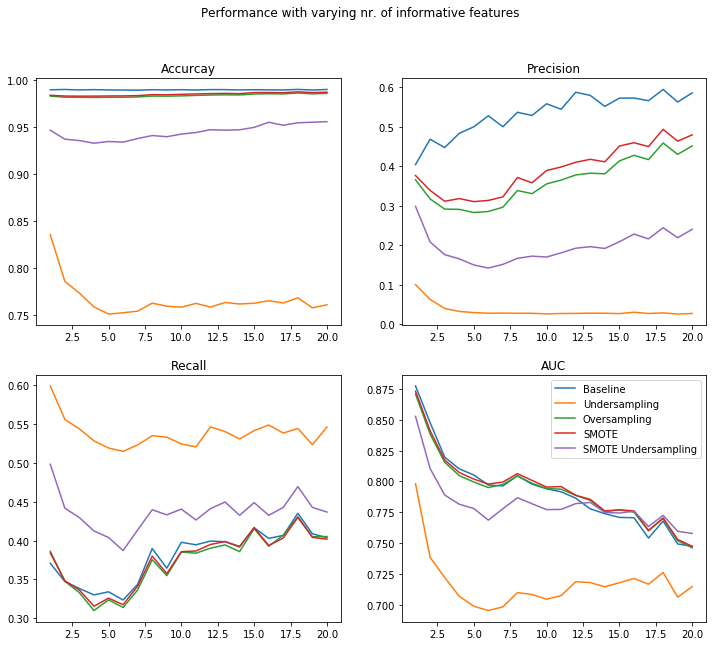

In [67]:
# Plot results
plot_results(accuracy_pd_features,precision_pd_features,
             recall_pd_features,auc_pd_features, title = 'Performance with varying nr. of informative features')